In [1]:
# imort packages
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf

2024-11-07 18:47:08.243958: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
base_dir = 'horse_or_human'

train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')

train_horses_dir = os.path.join(train_dir,'horses')
train_humans_dir = os.path.join(train_dir,'humans')

validation_horses_dir = os.path.join(validation_dir,'horses')
validation_humans_dir = os.path.join(validation_dir,'humans')

print("Contents of base dir:",base_dir)
print("Contents of train_dir:",train_dir)
print("Contents of validation_dir:",validation_dir)

Contents of base dir: horse_or_human
Contents of train_dir: horse_or_human/train
Contents of validation_dir: horse_or_human/validation


In [5]:
train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)

validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print()
print("len(train_horses_fnames):",len(train_horses_fnames))
print("len(train_humans_fnames):",len(train_humans_fnames))
print()
print("len(validation_horses_fnames):",len(validation_horses_fnames))
print("len(validation_humans_fnames):",len(validation_humans_fnames))
print()


len(train_horses_fnames): 500
len(train_humans_fnames): 528

len(validation_horses_fnames): 128
len(validation_humans_fnames): 128



In [7]:
Batch_Size = 32
Image_Size = (300,300)
Label_Mode = 'binary'

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size = Image_Size,
    batch_size = Batch_Size,
    label_mode = Label_Mode
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size = Image_Size,
    batch_size = Batch_Size,
    label_mode = Label_Mode
)

BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = train_dataset.cache().shuffle(buffer_size = BUFFER_SIZE).prefetch(buffer_size = PREFETCH_BUFFER_SIZE)
validation_dataset_final = validation_dataset.cache().shuffle(buffer_size = BUFFER_SIZE).prefetch(buffer_size = PREFETCH_BUFFER_SIZE)

Found 1028 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


In [9]:
def create_model():
    model = tf.keras.Sequential([
        
        tf.keras.Input(shape=(300,300,3)),
        tf.keras.layers.Rescaling(.1/255),
        
        tf.keras.layers.Conv2D(16,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.Dense(1,activation='sigmoid')

    ])
    return model

In [15]:
FILL_MODE = 'nearest'

data_augmentation = tf.keras.Sequential([
    tf.keras.Input(shape=(300,300,3)),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2,fill_mode = FILL_MODE),
    tf.keras.layers.RandomTranslation(0.2,0.2,fill_mode = FILL_MODE),
    tf.keras.layers.RandomZoom(0.2,fill_mode = FILL_MODE)
])

In [16]:
def demo_augmentation(sample_image, model, num_aug):
    '''Takes a single image array, then uses a model to generate num_aug transformations'''

    # Instantiate preview list
    image_preview = []

    # Convert input image to a PIL image instance
    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    # Append the result to the list
    image_preview.append(sample_image_pil)

    # Apply the image augmentation and append the results to the list
    for i in range(NUM_AUG):
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    # Instantiate a subplot
    fig, axes = plt.subplots(1, NUM_AUG + 1, figsize=(12, 12))

    # Preview the images.
    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()

        if index == 0:
            ax.set_title('original')
        else:
            ax.set_title(f'augment {index}')

2024-11-07 19:34:54.998207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1028]
	 [[{{node Placeholder/_4}}]]
2024-11-07 19:34:54.999986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1028]
	 [[{{node Placeholder/_4}}]]


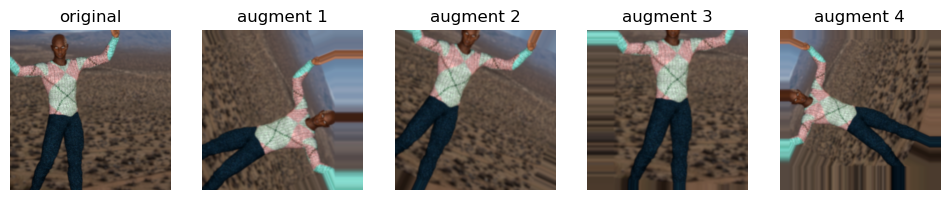

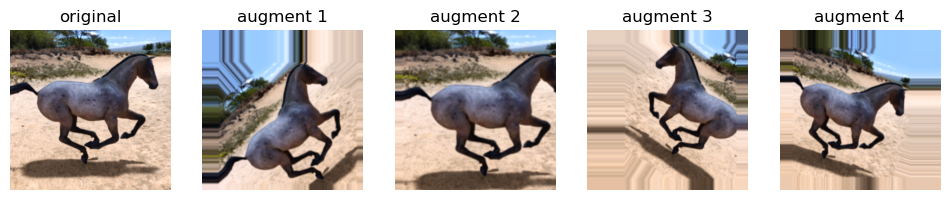

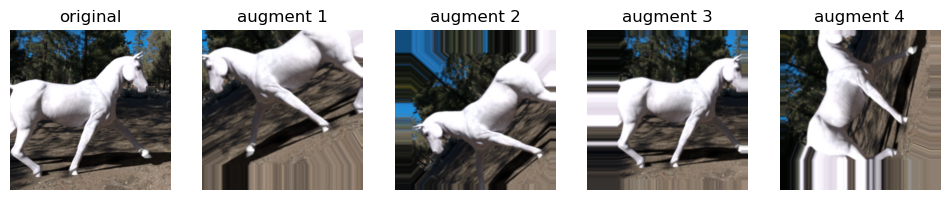

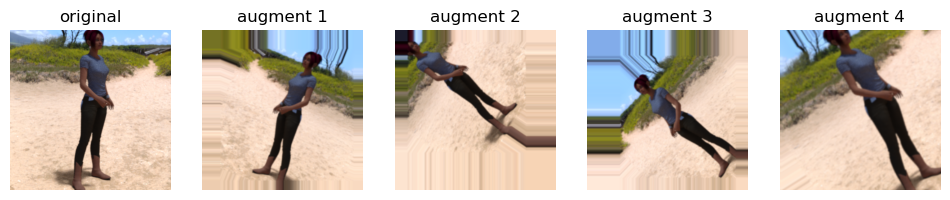

In [17]:
NUM_AUG = 4

# Get a batch of images
sample_batch = list(train_dataset.take(1))[0][0]

# Apply the transformations to the first 4 images
demo_augmentation(sample_batch[0], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[1], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[2], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[3], data_augmentation, NUM_AUG)

# Delete the variable to free up some memory
del sample_batch

In [18]:
unaugmented_model = create_model()

augmented_model = tf.keras.Sequential([
    data_augmentation,
    unaugmented_model
])

augmented_model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [23]:
history = augmented_model.fit(
    train_dataset_final,
    epochs=20,
    validation_data = validation_dataset_final,
    verbose = 2
)


Epoch 1/20


2024-11-07 19:46:25.834090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [256]
	 [[{{node Placeholder/_0}}]]
2024-11-07 19:46:25.838638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [256]
	 [[{{node Placeholder/_4}}]]


33/33 - 105s - loss: 0.6918 - accuracy: 0.5146 - val_loss: 0.6929 - val_accuracy: 0.5000 - 105s/epoch - 3s/step
Epoch 2/20
33/33 - 94s - loss: 0.6905 - accuracy: 0.5136 - val_loss: 0.6935 - val_accuracy: 0.5000 - 94s/epoch - 3s/step
Epoch 3/20
33/33 - 104s - loss: 0.6892 - accuracy: 0.5165 - val_loss: 0.6916 - val_accuracy: 0.5000 - 104s/epoch - 3s/step
Epoch 4/20
33/33 - 109s - loss: 0.6871 - accuracy: 0.5409 - val_loss: 0.6944 - val_accuracy: 0.5000 - 109s/epoch - 3s/step
Epoch 5/20
33/33 - 105s - loss: 0.6827 - accuracy: 0.5593 - val_loss: 0.6936 - val_accuracy: 0.5000 - 105s/epoch - 3s/step
Epoch 6/20
33/33 - 115s - loss: 0.6743 - accuracy: 0.5963 - val_loss: 0.6837 - val_accuracy: 0.5898 - 115s/epoch - 3s/step
Epoch 7/20
33/33 - 111s - loss: 0.6644 - accuracy: 0.6255 - val_loss: 0.6743 - val_accuracy: 0.7852 - 111s/epoch - 3s/step
Epoch 8/20
33/33 - 115s - loss: 0.6427 - accuracy: 0.6625 - val_loss: 0.6863 - val_accuracy: 0.5156 - 115s/epoch - 3s/step
Epoch 9/20
33/33 - 107s - los

In [24]:
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()

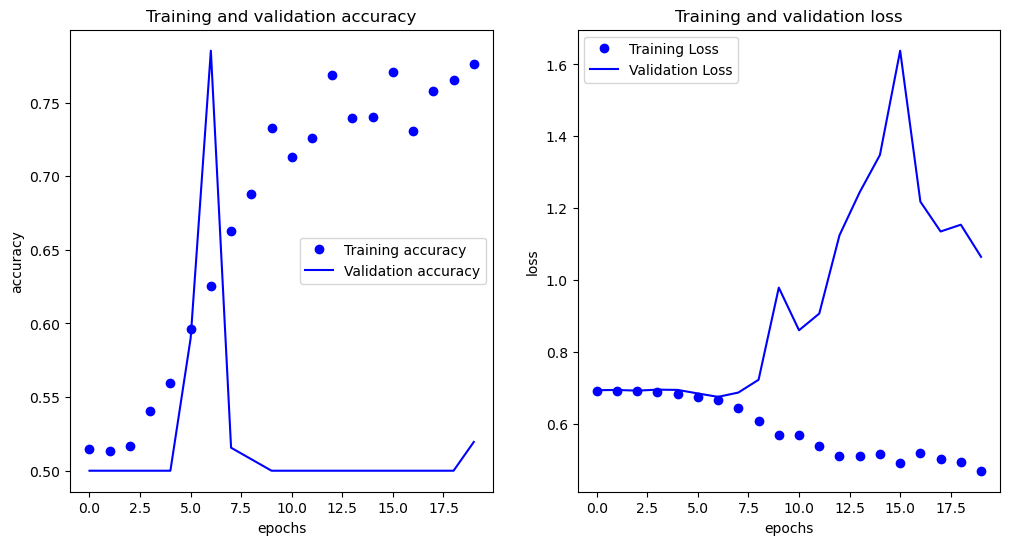

In [25]:
# Plot training results
plot_loss_acc(history)

In [27]:
def show_images(dir_1, dir_2):
    '''plots 8 images each from two given directories'''

    # Output images in a 2x8 configuration
    nrows = 2
    ncols = 8

    # Get filenames from the two directories
    fnames_dir_1 = os.listdir(dir_1)
    fnames_dir_2 = os.listdir(dir_2)

    # Set up matplotlib fig, and size it to fit 2x8 images
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)

    # Get 8 random filenames and set the full paths
    next_pix_dir_1 = [os.path.join(dir_1, fname)
                      for fname in random.sample(fnames_dir_1, 8)]
    next_pix_dir_2 = [os.path.join(dir_2, fname)
                      for fname in random.sample(fnames_dir_2, 8)]

    # Plot the chosen images
    for i, img_path in enumerate(next_pix_dir_1 + next_pix_dir_2):

        # Set up subplot. subplot indices start at 1
        sp = plt.subplot(nrows, ncols, i + 1)

        # Don't show axes or gridlines
        sp.axis('Off')

        # Load and show the image
        img = tf.keras.utils.load_img(img_path)
        plt.imshow(img)

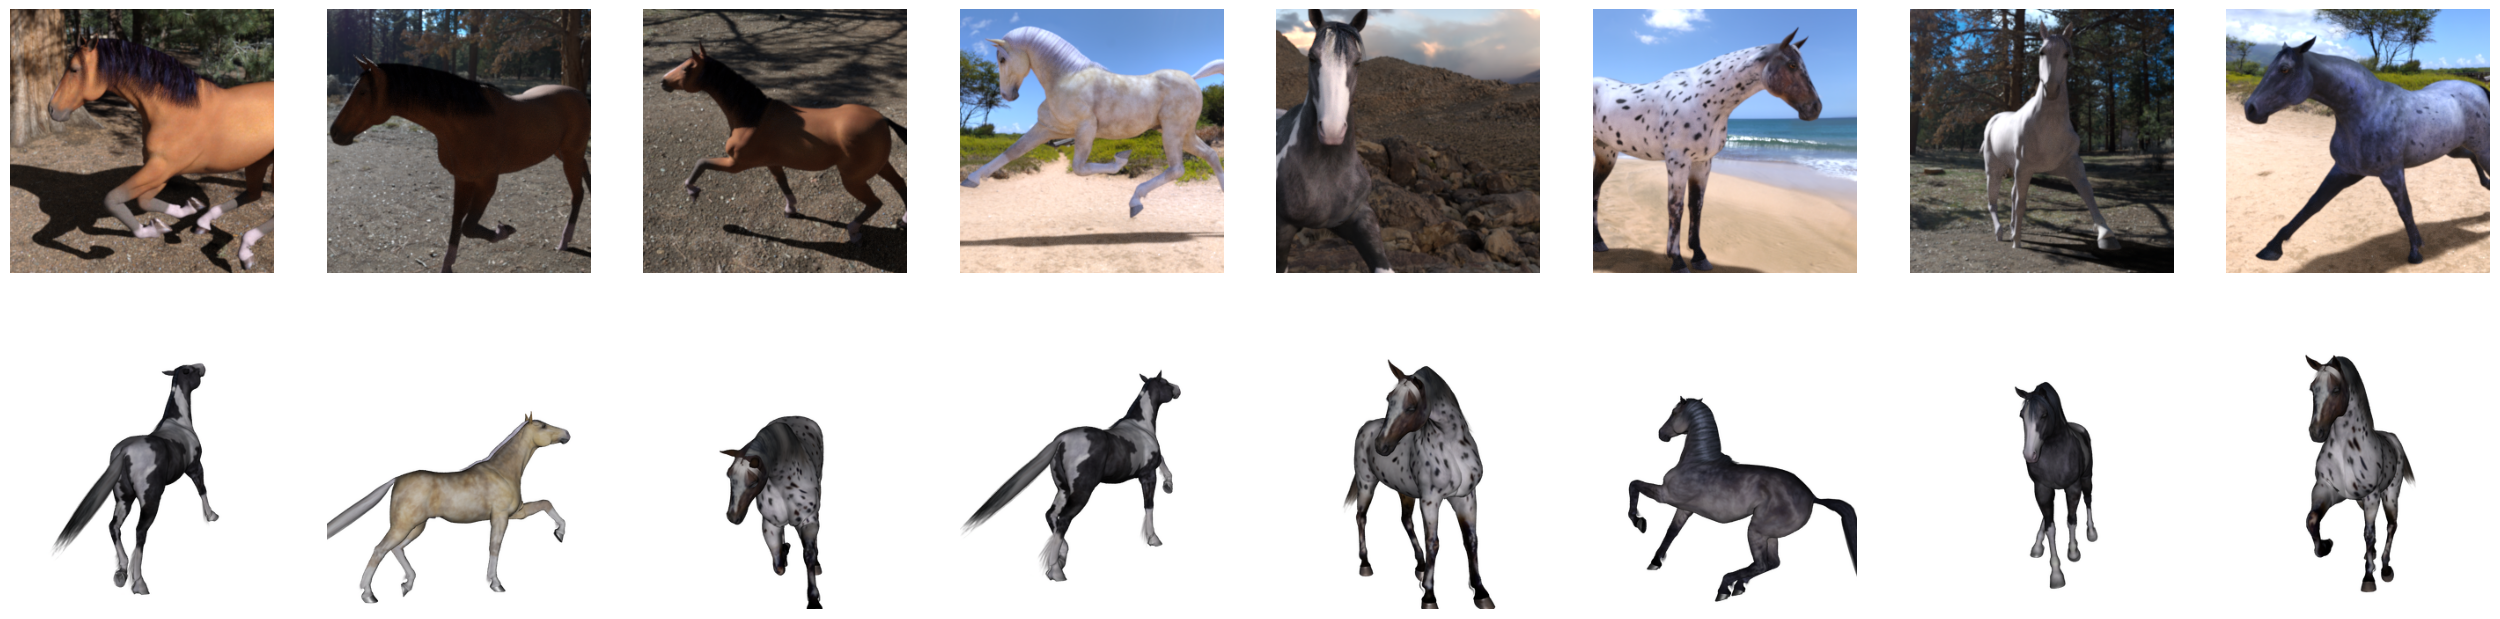

In [29]:
# Show random train (first row) and validation (second row) horse images
show_images(train_horses_dir, validation_horses_dir)

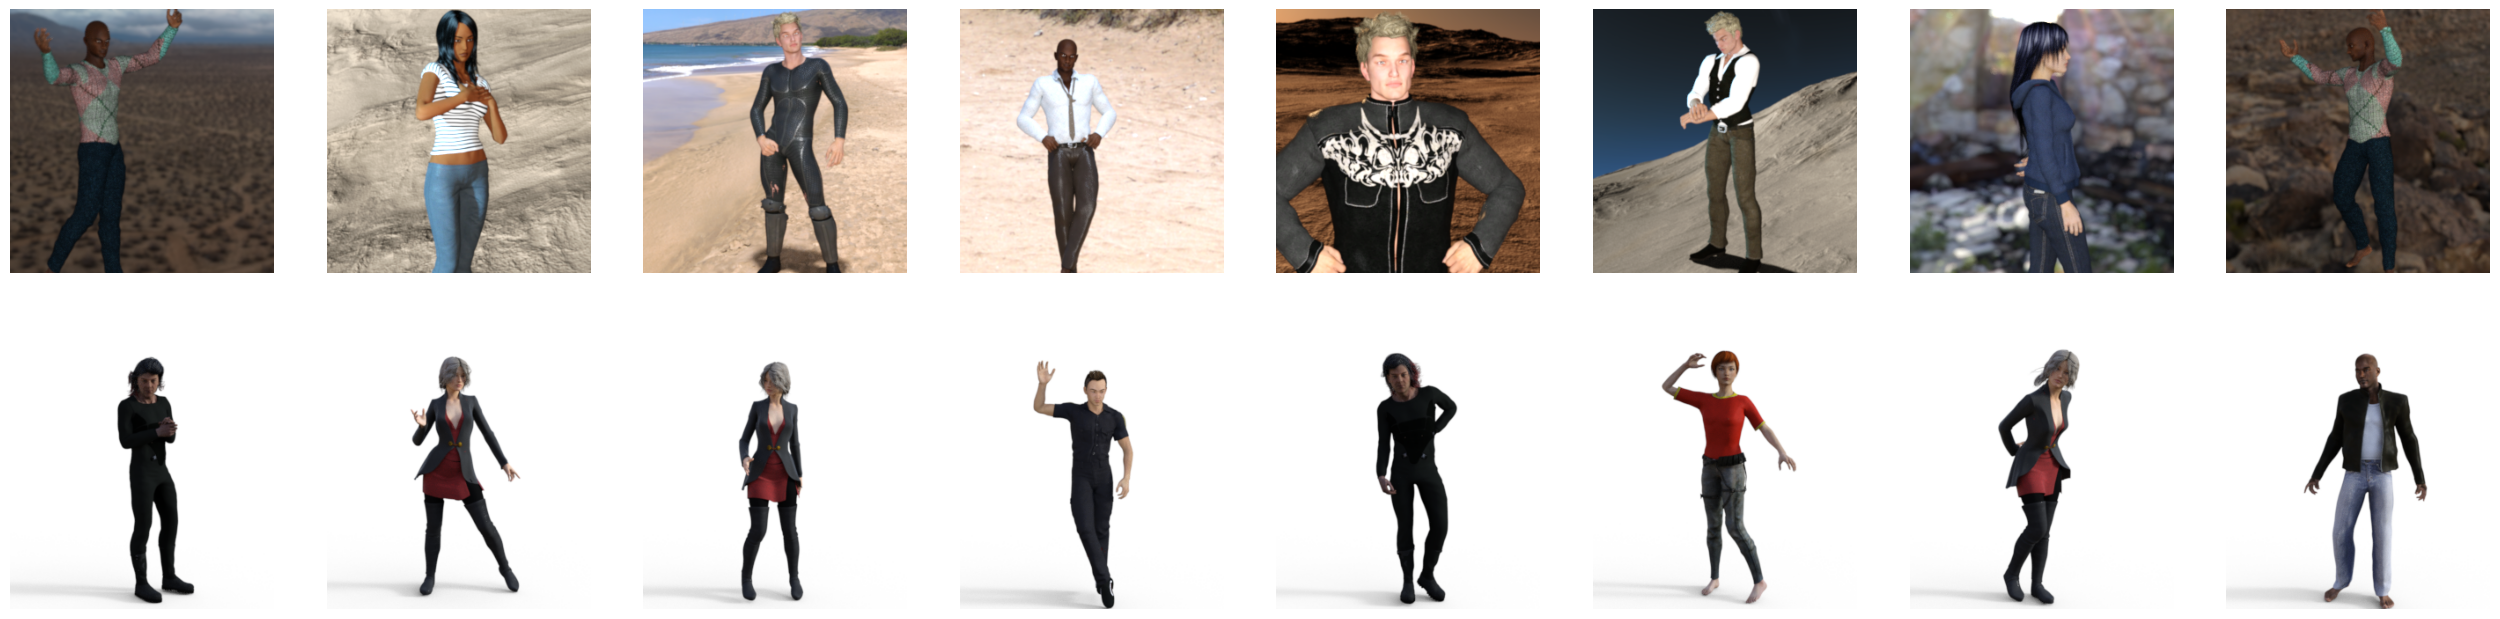

In [30]:
# Show random train (first row) and validation (second row) human images
show_images(train_humans_dir, validation_humans_dir)